# Exercises 5 NMSM

## Gillepsie algorithm and its application to Lotka-Volterra and Brussellator

#### Marco Zenari

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1542)

## Gillepsie algorithm

In [2]:
def gillespie(state, N_steps, reactions_rates, parameters, reaction):
    
    '''
        This function implements the gillespie algorithm for the stochasti evolution of 
        a continous time Markov Process
        
        Input:
            state --> a 1d numpy array representing the initial state of the system: 
                    state[i] is the initial population of species i;
            
            N_steps --> number of steps of evolution with gillespie algorithm; 
                    NB: each time intervall is extracted from an exponential distribution
            
            reactions_rates --> a function specific of the system that takes in input the
                            state of the system and the parameters of the systems and 
                            returns a numpy array with the rates of the reactions possibles
                            for the system in the given state
            parameters --> a numpy array with the parameters of the systems that enters in 
                        the calculation of the reaction rates
                        
            reaction --> a function specific of the system that given the state and the 
                    index of the reaction that is sampled returns the modified state
    '''
    
    state_story = np.zeros((N_steps, len(state) + 1))  #creating a np array to story the evolution
    state_story[0, 1:] = state   #initial state

    #Evolution
    for i in range(1, N_steps):
        rates = reactions_rates(state, parameters)  #computing the rates
        
        #RESIDENCE TIME
        lambda_escape = np.sum(rates)    #computing the escape rate
        delta_time = np.random.exponential(1/lambda_escape)  #sampling the residence time
        
        #TRANSITION
        probabilities = rates/lambda_escape   #normalizing the reactions probabilities 
        #sampling the reaction
        cumulative = np.cumsum(probabilities)
        np.append(cumulative, 0)
        r = np.random.uniform() 
        index = 0
        for j in range(0, len(cumulative)):
            if (cumulative[j-1] < r and cumulative[j] > r):
                index = j
        #applying the reaction to the state
        state = reaction(state, index)
        
        #storying the step of evolution
        state_story[i, 1:] = state
        state_story[i, 0] = state_story[i-1, 0] + delta_time
           
    return state_story 

## Lotka-Volterra

In [3]:
def LV_reactions_rates(state, parameters):
    #compute the rates of each reactions given the state of the system and the parameters of the system
    reaction_rates = np.zeros(3)
    
    reaction_rates[0] = parameters[0]*state[0]   #birth of a prey
    reaction_rates[1] = parameters[1]*state[0]*state[1]  #predation
    reaction_rates[2] = parameters[2]*state[1]  #death of a predator
    return reaction_rates

def LV_reaction(state, index):
    #return the state changed after applying interactin corresponding to index
    if(index == 0):
        #brith of a prey
        state[0] = state[0] + 1
    elif(index == 1):
        #predation
        state[0] = state[0] - 1
        state[1] = state[1] + 1
    elif(index == 2):
        #death of a predator
        state[1] = state[1] -1
        
    return state

In [4]:
# Parameters for the simulation
LV_parameters = [3, 1/100, 5]  #k1, k2, k3
N_steps = 50000  #duration of the simulation

#Stationary solution
stat_sol = np.ones((N_steps, 2))*[LV_parameters[2]/LV_parameters[1], LV_parameters[0]/LV_parameters[1]]

#Initial states
initial_state=[[500, 300], [500, 100], [200, 400], [100, 600], [10, 600], [300, 20]]

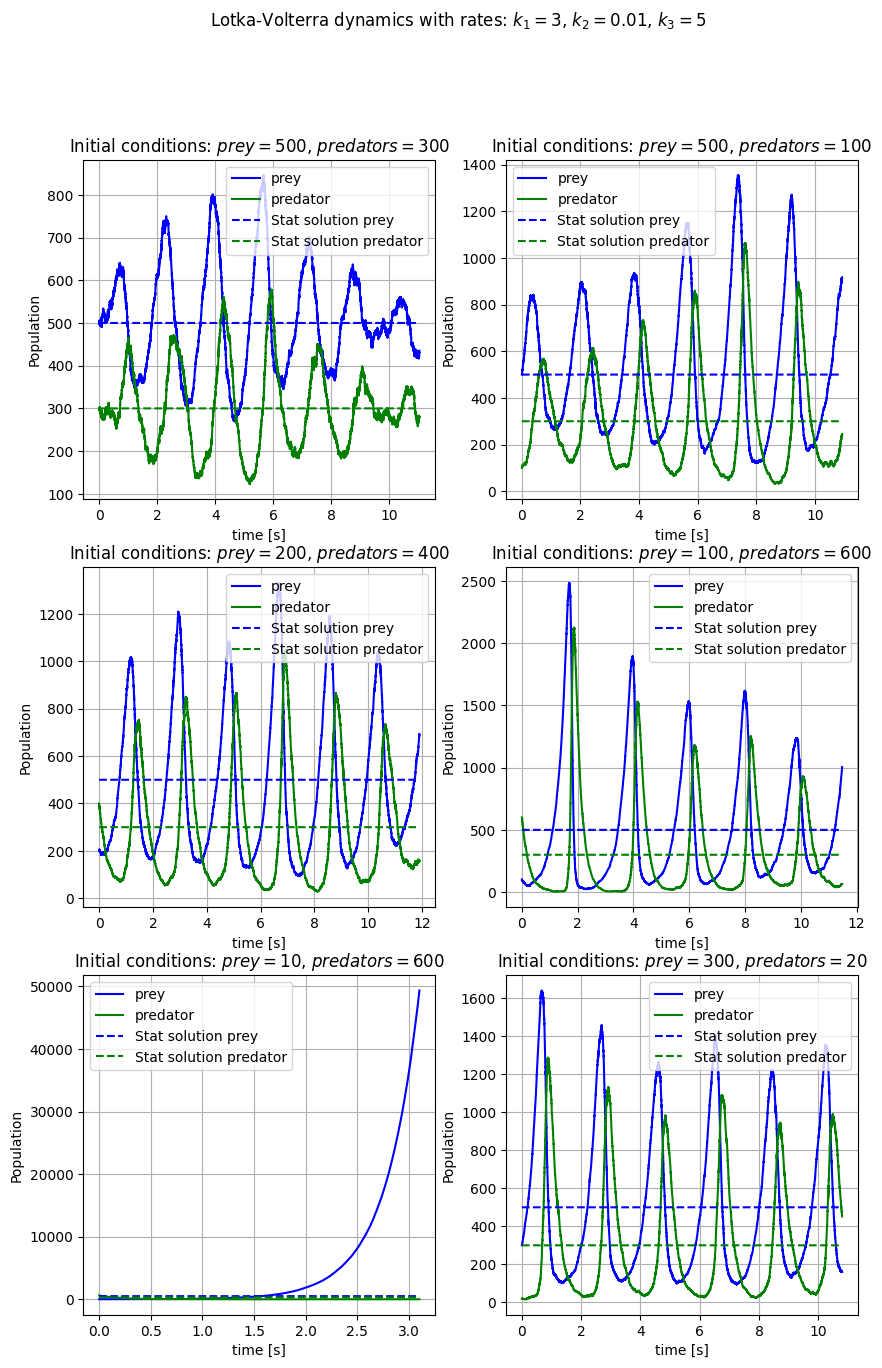

<Figure size 640x480 with 0 Axes>

In [5]:
fig, axs = plt.subplots(3, 2, figsize = (10, 15))
for i in range(6):
    state = initial_state[i].copy()#
    simul = gillespie(state, N_steps, LV_reactions_rates, LV_parameters, LV_reaction)
    axs[i//2, i%2].plot(simul[:,0], simul[:,1], c='blue', label='prey')
    axs[i//2, i%2].plot(simul[:,0], simul[:,2], c='green', label='predator')
    axs[i//2, i%2].plot(simul[:,0], stat_sol[:,0 ], c = 'blue', linestyle='dashed', label='Stat solution prey')
    axs[i//2, i%2].plot(simul[:,0], stat_sol[:,1 ], c = 'green', linestyle='dashed', label='Stat solution predator')
    axs[i//2, i%2].legend()
    axs[i//2, i%2].set_xlabel(r'time [s]')
    axs[i//2, i%2].set_ylabel(r'Population')
    axs[i//2, i%2].set_title(r'Initial conditions: $prey = {}$, $predators = {}$'.format(initial_state[i][0], initial_state[i][1]))
    axs[i//2, i%2].grid()
fig.suptitle(r'Lotka-Volterra dynamics with rates: $k_1={}$, $k_2={}$, $k_3={}$'.format(LV_parameters[0], LV_parameters[1], LV_parameters[2]))
plt.show()

In the previous plots we can see the oscillatory behavior of teh predator-prey system that evolves following the Lotka-Volterra model. The poupulations of prey and predator oscillates around their stationary solution (prey = $k_3/k_2$, predator =$k_1/k_2$) with oscillations amplituted that are somehow related to the initial codnition: if the initial condition is close to the stationary the oscillations amplitudes are smaller then if the initial conditions are far from the stationary solution. We can also see that the predator oscillations are in delayed phase, as expected from a cause-effect point of view: a lot of preys will be followed by an increase of predators while a low number of preys will be followed by a low nomber of predators. If eventually the predators go extinct the preys grow exponentially, as expected since the only rate different from zero is $\omega_1 = k_1 \cdot X_1$. This can happen if we star with to many predators respect to the number of preys: having no food they will die. Another possibility is to increase the death rate of the predators $k_3$ and reducing the predation rate $k_2$.

## Brusellator

In [7]:
def Brusellator_reactions_rates(state, parameters):
    #compute the rates of each reactions given the state of the system and the parameters of the system
    reaction_rates = np.zeros(4)
    
    reaction_rates[0] = parameters[0]*parameters[2] 
    reaction_rates[1] = state[0]  
    reaction_rates[2] = 1/parameters[2]**2*state[0]*(state[0]-1)*state[1] 
    reaction_rates[3] = parameters[1]*state[0]
    return reaction_rates

def Brusellator_reaction(state, index):
    #return the state changed after applying interactin corresponding to index
    if(index == 0):
        state[0] = state[0] + 1
    elif(index == 1):
        state[0] = state[0] - 1
    elif(index == 2):
        state[0] = state[0] + 1
        state[1] = state[1] - 1
    elif(index == 3):
        state[0] = state[0] - 1
        state[1] = state[1] + 1
        
    return state

In [8]:
# Parameters for the simulation
Omega = [100, 1000, 10000]
a = 2
b = 5
N_steps_values = [100000, 500000, 2500000] #duration of the simulation

#Initial states
initial_state=[1000, 1000]

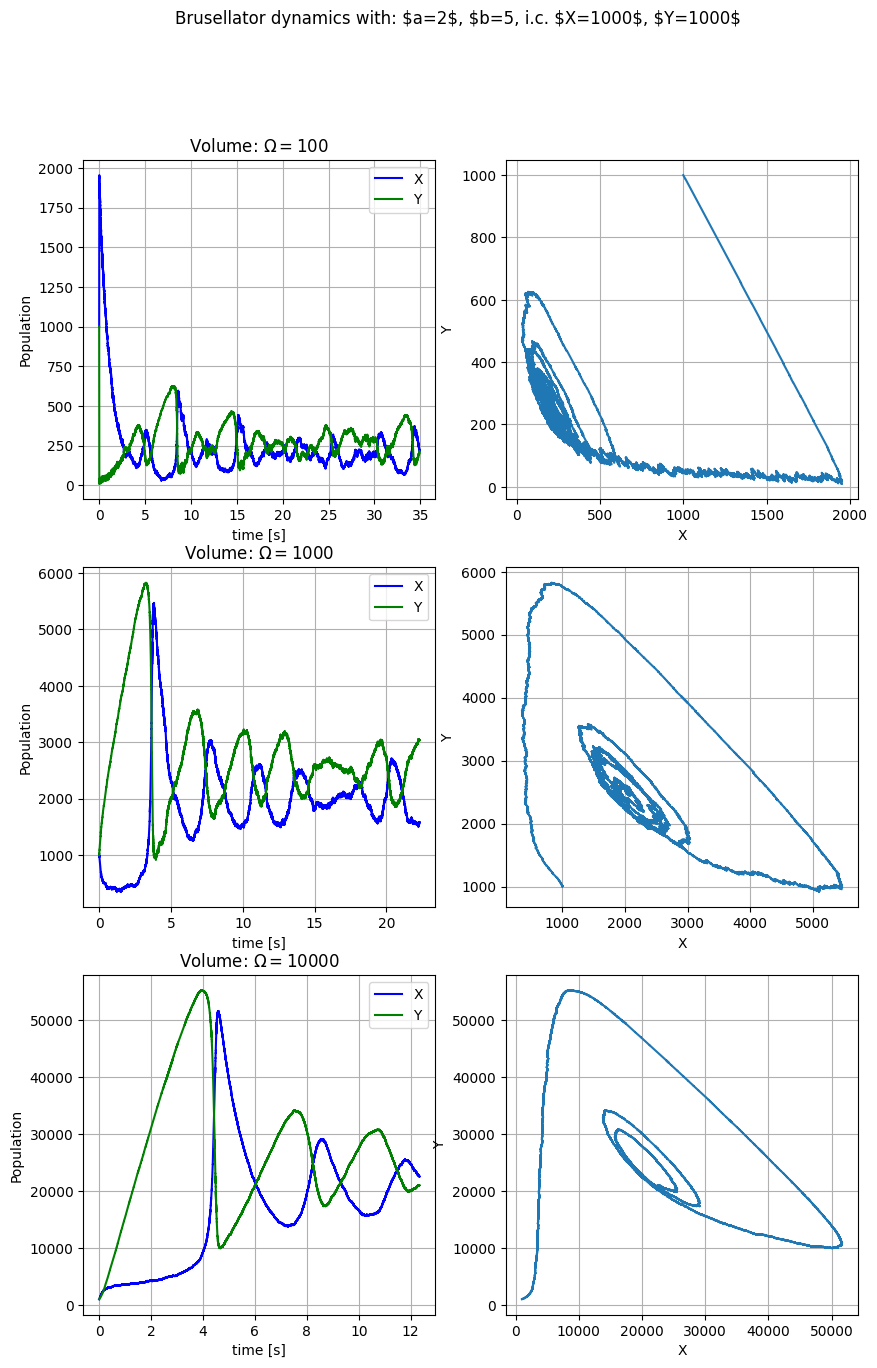

In [9]:
fig, axs = plt.subplots(3, 2, figsize = (10, 15))
for i in range(3):
    Brusellator_parameters = [a, b, Omega[i]]  #a, b, Omeg
    state = initial_state.copy()
    simul = gillespie(state, N_steps_values[i], Brusellator_reactions_rates, Brusellator_parameters, Brusellator_reaction)
    axs[i, 0].plot(simul[:,0], simul[:,1], c='blue', label='X')
    axs[i, 0].plot(simul[:,0], simul[:,2], c='green', label='Y')
    axs[i, 0].legend()
    axs[i, 0].set_xlabel(r'time [s]')
    axs[i, 0].set_ylabel(r'Population')
    axs[i, 0].set_title(r'Volume: $\Omega = {}$'.format(Brusellator_parameters[2]))
    axs[i, 0].grid()
    
    axs[i, 1].plot(simul[:,1], simul[:,2])
    axs[i, 1].set_xlabel(r'X')
    axs[i, 1].set_ylabel(r'Y')
    axs[i, 1].grid()
    
fig.suptitle(r'Brusellator dynamics with: $a={}$, $b={}, i.c. $X={}$, $Y={}$'.format(
    Brusellator_parameters[0], Brusellator_parameters[1], initial_state[0], initial_state[1]))
plt.show()

In [10]:
fig.savefig('plots/brusselator.png')

If we start with a small volume $\Omega$, lets say $\Omega = 100$ the third reaction is more likely to happen giving arise to a spike of creations of molecule of type $X$. When the number of $X$ is high enough, because of the fact that both the second and the fourth reactions are proportional to $X$ there is a suddenly decrease of $X$ in favor of $Y$. This brings to an oscillatory behavior with high freqeuncy. Whene $\Omega$ is of the magnitude of order of $X$ and $Y$ the frequency of oscillations is smaller and in the limit of huge volume $\Omega$ the frequency of oscillations increase. In the phase space this means that the greather the volume is the greather the dimension of the atractor will be.